## Задача

Есть выборка статей с популярного англоязычного портала Medium. Задача – спрогнозировать число рекомендаций ("лайков") статьи. Предлагается Вам самим составить обучающую и тестовую выборки на основе имеющихся данных, обучить модель-регрессор и сформировать файл посылки с прогнозами – числом рекомендаций статей (с <code>log1p</code>-преобразованием) из тестовой выборки.

## Данные

Обучающая выборка – 52699 статей, опубликованных до 2016 года включительно (<strong>train.zip</strong> ~ 480 Mb, unzip ~1.6 Gb). Тестовая выборка – 39492 статьи, опубликованные с 1 января по 27 июня 2017 года (<strong>test.zip</strong> ~425 Mb, unzip ~1.4 Gb).

Данные о статьях представлены в JSON формате с полями:

<li>_id и url – URL статьи
<li>published – время публикации
<li>title – название статьи
<li>author – имя автора, его акканут на Твиттере и Medium
<li>content – HTML-контент статьи
<li>meta_tags – остальная информация о статье
<br>
<br>В файле <strong>train_log1p_recommends.csv</strong> представлены номера (id) статей из обучающей выборки вместе с целевым показателем: числом рекомендаций статей, к которому применено преобразование <code>log1p(x) = log(1 + x)</code> В файле <strong>sample_submission.csv</strong> представлен пример файла посылки.

In [3]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

In [4]:
path_to_train = "C://Users/Nikolay/Desktop/IT/kaggle/how_good_is_your_article/train.json"

In [5]:
PATH_TO_DATA = "C://Users/Nikolay/Desktop/IT/kaggle/how_good_is_your_article/"

The following code will help to throw away all HTML tags from an article content.

In [6]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [7]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article content. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [8]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [9]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'train.json'),)

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_1800\3908882518.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):


0it [00:00, ?it/s]

CPU times: total: 1min 55s
Wall time: 1min 55s


In [10]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'test.json'),)

C:\Users\Nikolay\AppData\Local\Temp\ipykernel_1800\3908882518.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):


0it [00:00, ?it/s]

CPU times: total: 1min 8s
Wall time: 1min 8s


We'll use a linear model (Ridge) with a very simple feature extractor – CountVectorizer, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features.

In [11]:
cv = CountVectorizer(max_features=50000)

In [12]:
%%time
X_train = cv.fit_transform(train_raw_content)

CPU times: total: 46.4 s
Wall time: 46.4 s


In [13]:
X_train

<62313x50000 sparse matrix of type '<class 'numpy.int64'>'
	with 33479333 stored elements in Compressed Sparse Row format>

In [14]:
%%time
X_test = cv.transform(test_raw_content)

CPU times: total: 22.9 s
Wall time: 22.9 s


In [15]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

Read targets from file.

In [16]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [17]:
train_target.shape

(62313, 1)

In [18]:
y_train = train_target['log_recommends'].values

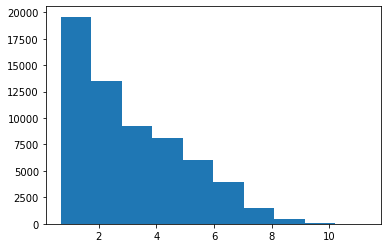

In [19]:
plt.hist(y_train);  # zero inflation -- много нулей в выборке

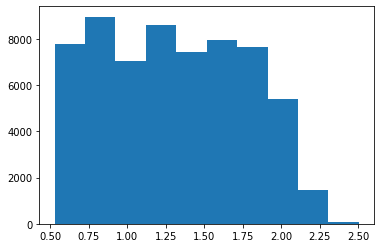

In [20]:
plt.hist(np.log1p(y_train));

Make a 30%-holdout set.

In [21]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

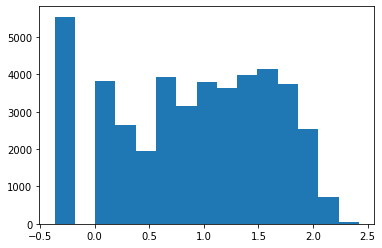

In [22]:
plt.hist(np.log(y_train_part), bins = 15);

Now we are ready to fit a linear model.

In [23]:
from sklearn.linear_model import Ridge

In [24]:
ridge = Ridge(random_state=17)

In [25]:
%%time
ridge.fit(X_train_part, y_train_part);

CPU times: total: 11min 2s
Wall time: 11min 30s


Ridge(random_state=17)

In [26]:
ridge_pred = ridge.predict(X_valid)

In [27]:
valid_mae = mean_absolute_error(y_valid,ridge_pred)

In [28]:
valid_mae, np.expm1(valid_mae)

(3.850348168706656, 46.00942759424061)

As we can see, the prediction is far from perfect, and we get MAE  ≈  1.3 that corresponds to  ≈  2.7 error in #recommendations.

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the np.log1p transformation.

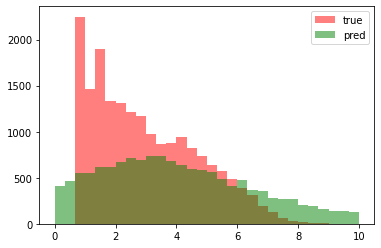

In [29]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

Finally, train the model on the full accessible training set, make predictions for the test set and form a submission file.

In [30]:
ridge = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [31]:
%%time
ridge.fit(X_train, y_train)

C:\Users\Nikolay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


CPU times: total: 1min 23s
Wall time: 1min 25s


Ridge(normalize=False, random_state=17)

In [32]:
%%time
ridge_pred = ridge.predict(X_test)

CPU times: total: 62.5 ms
Wall time: 58.8 ms


In [33]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [34]:
write_submission_file(prediction=ridge_pred, 
                      filename='first_ridge.csv')

In [35]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression, Lasso
lasso = Lasso(random_state = 17)

In [37]:
def train_validate_report(model, X_train_scaled, y_train,
                          X_valid_scaled, y_valid, forest = False):
    model.fit(X_train_scaled, y_train)
    print("MSE=%f" % mean_absolute_error(y_valid, model.predict(X_valid_scaled)))

In [38]:
%%time
train_validate_report(lasso, X_train, y_train, X_valid, y_valid)

MSE=1.451570
CPU times: total: 2min 36s
Wall time: 2min 36s


In [39]:
%%time
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
write_submission_file(prediction=lasso_pred, 
                      filename='first_lasso.csv')

CPU times: total: 2min 36s
Wall time: 2min 36s


## TFIDF
<br> Total frequency

In [40]:
tfidf = TfidfVectorizer(max_features=100000)

In [41]:
%%time
X_train = tfidf.fit_transform(train_raw_content)

CPU times: total: 53 s
Wall time: 53 s


In [42]:
%%time
X_test = tfidf.transform(test_raw_content)

CPU times: total: 25.7 s
Wall time: 25.7 s


In [43]:
X_train.shape, X_test.shape

((62313, 100000), (34645, 100000))

In [44]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [45]:
train_target.shape

(62313, 1)

In [46]:
y_train = train_target['log_recommends'].values

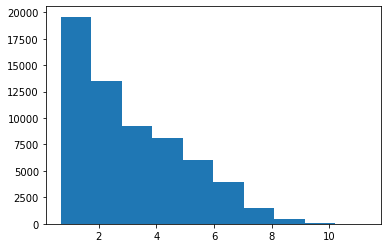

In [47]:
plt.hist(y_train);  # zero inflation -- много нулей в выборке

In [48]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

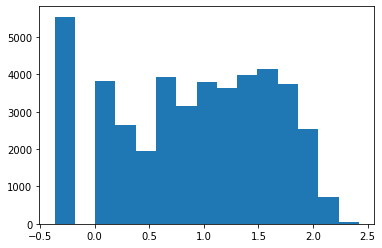

In [49]:
plt.hist(np.log(y_train_part), bins = 15);

In [50]:
ridge = Ridge(random_state=17)

In [51]:
%%time
ridge.fit(X_train_part, y_train_part);

CPU times: total: 3.62 s
Wall time: 3.72 s


Ridge(random_state=17)

In [52]:
%%time
ridge_pred = ridge.predict(X_test)

CPU times: total: 46.9 ms
Wall time: 36.9 ms


In [53]:
write_submission_file(prediction=ridge_pred, 
                      filename='second_ridge.csv') # Score: 1.79128
                                                   # Public score: 1.80165

In [54]:
%%time
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
write_submission_file(prediction=lasso_pred, 
                      filename='second_lasso.csv')   # 2.05

CPU times: total: 8.53 s
Wall time: 8.53 s


In [55]:
from sklearn.linear_model import LassoCV, RidgeCV

In [56]:
lasso_cv = LassoCV(random_state = 17)
ridge_cv = RidgeCV()

In [58]:
%time
lasso_cv.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


KeyboardInterrupt: 

In [ ]:
lasso_cv_pred = lasso.predict(X_test)
write_submission_file(prediction=lasso_cv_pred, 
                      filename='lasso_cv.csv')   # 

In [ ]:
%time
lasso_cv.fit(X_train, y_train)